# Main Preprocessing

# New Section

In [2]:
#Only use this when we want to do Optuna analysis
'''
#Bayesian Optimiser using Optuna Library for XGBoost
!pip install optuna
'''

'\n#Bayesian Optimiser using Optuna Library for XGBoost\n!pip install optuna\n'

In [3]:
# This is extracting data from the csv

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_parquet("conso_data.parquet")
df_future = pd.read_parquet("conso_data.parquet")

# 1. Handle missing values (Fill or Drop)
df.dropna(inplace=True)  # Remove missing values for simplicity
df_future.dropna(inplace=True)  # Remove missing values for simplicity

# Current Pricing

In [4]:
# 2. Convert 'month' to numerical features (Extract year & month)
df['year'] = df['month'].apply(lambda x: int(x.split("-")[0]))
df['month'] = df['month'].apply(lambda x: int(x.split("-")[1]))

'''
Since the 1990 data doesn't have remaining_lease, and it's redundant with commencement date, I'm taking it off
# 3. Convert 'remaining_lease' to numerical years
df['remaining_lease'] = df['remaining_lease'].str.extract('(\d+)').astype(float)
'''

# 4. Convert 'storey_range' to approximate floor level (take the median)
def storey_to_category(storey_range):
    ranges = storey_range.split(" TO ")
    median = (int(ranges[0]) + int(ranges[1])) / 2 if len(ranges) == 2 else int(ranges[0])

    if median <= 6:
        return 1
    elif 7 <= median <= 12:
        return 2
    else:
        return 3

df['storey_median'] = df['storey_range'].apply(storey_to_category)

# 5. Calculate the age of the flat
df['flat_age'] = df['year'] - df['lease_commence_date']

# 6. One-hot encoding for categorical features
categorical_features = ['street_name', 'flat_type']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 7. Drop unnecessary columns
df.drop(['block', 'town', 'storey_range', 'remaining_lease','flat_model'], axis=1, inplace=True)

# 8. I want to print the data so far
df.head()

,month,floor_area_sqm,lease_commence_date,resale_price,year,storey_median,flat_age,street_name_ADMIRALTY LINK,street_name_AH HOOD RD,street_name_ALEXANDRA RD,...,street_name_YUNG PING RD,street_name_YUNG SHENG RD,street_name_ZION RD,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,flat_type_MULTI-GENERATION
0,1,31.0,1977,9000.0,1990,2,13,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,31.0,1977,6000.0,1990,1,13,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,31.0,1977,8000.0,1990,2,13,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,31.0,1977,6000.0,1990,2,13,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,73.0,1976,47200.0,1990,1,14,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [5]:
X_test_head = df.head(10)  # Select first 10 rows
X_test_head.to_csv("X_test_head.csv", index=False)  # Save to CSV
print("CSV file 'X_test_head.csv' created with the first 10 rows of X_test.")

CSV file 'X_test_head.csv' created with the first 10 rows of X_test.


In [6]:
# This is data processing & split preparation

# 1. Feature Scaling (Normalize numerical data)
numerical_features = ['floor_area_sqm', 'storey_median', 'flat_age']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 2. Train-test split
X = df.drop(columns=['resale_price']) #added storey_median here so we can test how it performs without that
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Data saved.")

Preprocessing complete. Data saved.


In [7]:
# Save the scaler
import pickle
with open('scaler.pkl', 'wb') as file:  # Open a file in write binary mode ('wb')
    pickle.dump(scaler, file)         # Dump the scaler object into the file

In [8]:
#This is linear regression function, just for baseline comparisonn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Initialize and train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 50239.14
RMSE: 66134.67
R² Score: 0.8604


In [9]:
'''

Bunch of remarks
One day we can check about plotting but lazy
MOP has no impact

'''

'\n\nBunch of remarks\nOne day we can check about plotting but lazy\nMOP has no impact\n\n'

In [10]:
#here we are testing the model against other methodology such as RF or XGB
#This and the other method don't need to be run again, only the one after Optuna optimisation is to be used
'''
from xgboost import XGBRegressor


# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train.values.ravel())
xgb_pred = xgb_model.predict(X_test)

# Evaluate both models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

evaluate_model(y_test, xgb_pred, "XGBoost")
#XGBoost (100,0.1) - MAE: 52427.64, RMSE: 69806.95, R²: 0.8464
'''

XGBoost - MAE: 33760.34, RMSE: 49131.32, R²: 0.9229


In [11]:
'''
# Train Random Forest

#Random Forest cannot be pickled, it always extend to like close to 1gb file
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth =5, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())  # .ravel() ensures proper shape
rf_pred = rf_model.predict(X_test)

evaluate_model(y_test, rf_pred, "Random Forest")

#Random Forest (50,5) - MAE: 76993.27, RMSE: 107547.88, R²: 0.6353, doesn't seem like we can reduce the depth, so this is stuck because of pickling size issue
'''

'\n# Train Random Forest\n\n#Random Forest cannot be pickled, it always extend to like close to 1gb file\nfrom sklearn.ensemble import RandomForestRegressor\nrf_model = RandomForestRegressor(n_estimators=50, max_depth =5, random_state=42)\nrf_model.fit(X_train, y_train.values.ravel())  # .ravel() ensures proper shape\nrf_pred = rf_model.predict(X_test)\n\nevaluate_model(y_test, rf_pred, "Random Forest")\n\n#Random Forest (50,5) - MAE: 76993.27, RMSE: 107547.88, R²: 0.6353, doesn\'t seem like we can reduce the depth, so this is stuck because of pickling size issue\n'

In [12]:
'''
#Train using Neural Network
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

# Assuming X_train, y_train, X_test, y_test are already defined as Pandas DataFrames

# Create and train the neural network model
nn_model = MLPRegressor(hidden_layer_sizes=(5, 2), activation='relu', solver='adam', random_state=42,batch_size=5000, learning_rate_init=1)
nn_model.fit(X_train, y_train.values.ravel()) # ravel() is used to flatten y_train if needed

# Make predictions
y_pred = nn_model.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred, "Neural Network")

#Neural Network - MAE: 76051.18, RMSE: 99628.21, R²: 0.6871 run around 3 mins
'''

'\n#Train using Neural Network\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.metrics import mean_absolute_error\n\n# Assuming X_train, y_train, X_test, y_test are already defined as Pandas DataFrames\n\n# Create and train the neural network model\nnn_model = MLPRegressor(hidden_layer_sizes=(5, 2), activation=\'relu\', solver=\'adam\', random_state=42,batch_size=5000, learning_rate_init=1)\nnn_model.fit(X_train, y_train.values.ravel()) # ravel() is used to flatten y_train if needed\n\n# Make predictions\ny_pred = nn_model.predict(X_test)\n\n# Evaluate the model\nevaluate_model(y_test, y_pred, "Neural Network")\n\n#Neural Network - MAE: 76051.18, RMSE: 99628.21, R²: 0.6871 run around 3 mins\n'

In [13]:
#DO NOT RUN THIS CELL IT TAKES LIKE 90 MINS TO TEST ALL COMBINATION
'''
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 10)
    }

    xgb_model_tuned = XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    xgb_model_tuned.fit(X_train, y_train)
    y_pred = xgb_model_tuned.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

#Parameters printing
print("Best parameters:", study.best_trial.params)
'''

#{'max_depth': 8, 'learning_rate': 0.29816288181757516, 'n_estimators': 463, 'min_child_weight': 8, 'subsample': 0.7784837367009123, 'colsample_bytree': 0.7366592236791326, 'gamma': 0.03016833782462212, 'reg_alpha': 0.911873200628761, 'reg_lambda': 2.8733206177988944}

'\nimport optuna\n\ndef objective(trial):\n    params = {\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.3),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 500),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.3, 1),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 0.01, 10),\n        \'reg_alpha\': trial.suggest_loguniform(\'reg_alpha\', 0.01, 1),\n        \'reg_lambda\': trial.suggest_loguniform(\'reg_lambda\', 1, 10)\n    }\n\n    xgb_model_tuned = XGBRegressor(**params, objective="reg:squarederror", random_state=42)\n    xgb_model_tuned.fit(X_train, y_train)\n    y_pred = xgb_model_tuned.predict(X_test)\n    return mean_squared_error(y_test, y_pred)\n\nstudy = optuna.create_study(dir

In [14]:
#Evaluation

#Copy the value from Optuna above

final_model = XGBRegressor(max_depth=8, learning_rate=0.29816288181757516, n_estimators=463, min_child_weight=8, subsample=0.7784837367009123, colsample_bytree=0.7366592236791326, gamma=0.03016833782462212, reg_alpha=0.911873200628761, reg_lambda=2.8733206177988944)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print(f"Final MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Final R2: {r2_score(y_test, y_pred)}")


Final MSE: 549141376.0
Final R2: 0.9824708104133606


In [15]:
#choose the winner and pickle it
import pickle

output = open('final_model.pkl', 'wb')
pickle.dump(final_model, output)
output.close()

# Testing and Others

In [16]:
#This is for sanity testing, upload the file before running this to avoid error
'''
import pandas as pd
import pickle

# 1. Load the scaler and model
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
with open('final_model.pkl', 'rb') as file:
    model = pickle.load(file)

# 2. Read X_single_test_data from CSV
X_single_test = pd.read_csv("X_single_test_data.csv")  # Replace with your CSV filename

# 3. Select numerical features for scaling
numerical_features = ['floor_area_sqm', 'storey_median', 'flat_age']

# 4. Scale the numerical features
X_single_test[numerical_features] = scaler.transform(X_single_test[numerical_features])

# 5. Make prediction
predicted_price = model.predict(X_single_test)
print(f"Predicted Price: {predicted_price}")
'''

FileNotFoundError: [Errno 2] No such file or directory: 'X_single_test_data.csv'

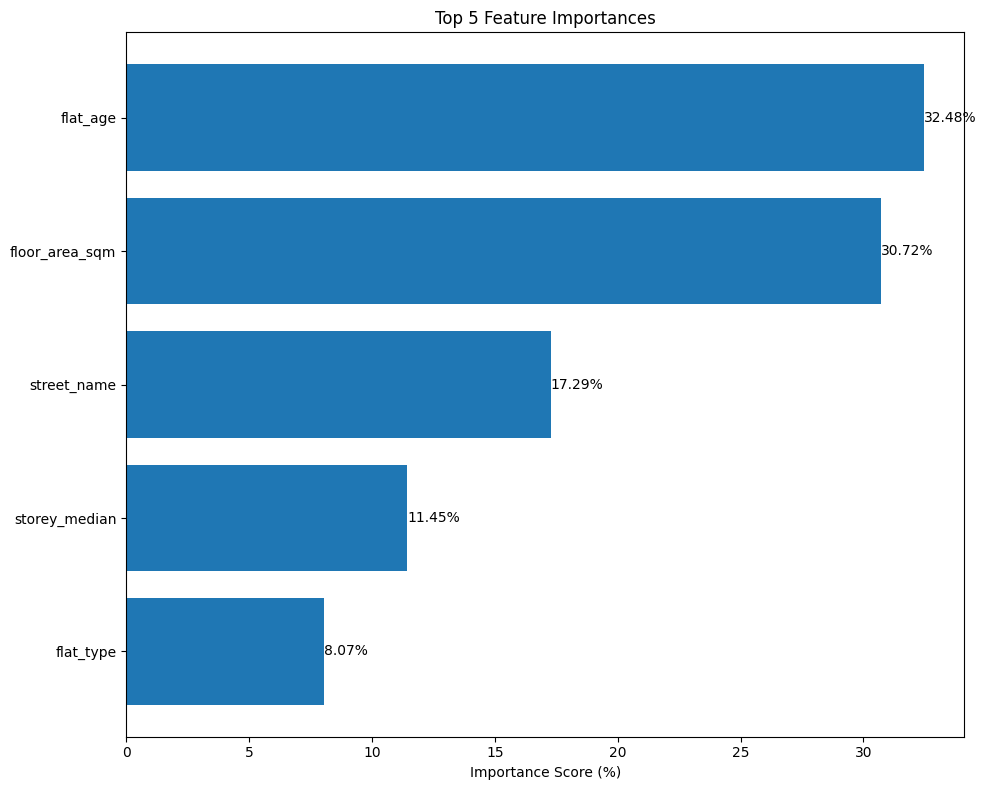

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np #import numpy for percentage calculation

# Get feature importance scores as a dictionary
importance = model.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame for easier plotting and sorting
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Exclude 'year' and 'month'
importance_df = importance_df[~importance_df['Feature'].isin(['year', 'month'])]

# Group flat types and sum importance
flat_type_features = [col for col in importance_df['Feature'] if 'flat_type_' in col]
flat_type_importance = importance_df.loc[importance_df['Feature'].isin(flat_type_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(flat_type_features)]  # Remove individual flat type features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['flat_type'], 'Importance': [flat_type_importance]})] , ignore_index=True)

# Group street names and sum importance
street_name_features = [col for col in importance_df['Feature'] if 'street_name_' in col]
street_name_importance = importance_df.loc[importance_df['Feature'].isin(street_name_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(street_name_features)]  # Remove individual street name features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['street_name'], 'Importance': [street_name_importance]})] , ignore_index=True)

# Combine flat_age and lease_commence_date into flat_age
age_features = ['flat_age', 'lease_commence_date']
combined_age_importance = importance_df.loc[importance_df['Feature'].isin(age_features), 'Importance'].sum()
importance_df = importance_df[~importance_df['Feature'].isin(age_features)] # Remove individual age features
importance_df = pd.concat([importance_df, pd.DataFrame({'Feature': ['flat_age'], 'Importance': [combined_age_importance]})] , ignore_index=True)


# Calculate percentage importance
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top features with percentages
top_n = 5
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])

# Add percentages next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', ha='left', va='center')

plt.xlabel('Importance Score (%)')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()